## Train Unet Segmentation Model 

In [17]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import UpSampling2D, Conv2D, MaxPooling2D, Activation, BatchNormalization
import numpy as np
import glob
import os
import pickle
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from livelossplot.keras import PlotLossesCallback

In [18]:
input_n=128

In [37]:
def keras_generator(gen_df, batch_size, input_n):
    while True:
        x_batch = []
        y_batch = []
        
        i = 0
        while i < batch_size:
            img_name, mask_name = gen_df.sample(1).values[0]
            try:
                img=np.load(img_name).reshape(input_n,input_n,3)
                mask=np.load(mask_name).reshape(input_n,input_n,1)                    
            except:
                i-=1
                continue
                
            x_batch += [img]
            y_batch += [mask]
            
            i += 1
        
        x_batch = np.array(x_batch)/ 255.
        y_batch = np.array(y_batch)

        yield x_batch, y_batch 

In [38]:
def construct_unet(input_n):
    inp = Input(shape=(input_n,input_n, 3))

    conv_1_1 = Conv2D(32, 3, padding='same')(inp)
    conv_1_1 = BatchNormalization(axis=3)(conv_1_1)
    conv_1_1 = Activation('relu')(conv_1_1)

    conv_1_2 = Conv2D(32, 3, padding='same')(conv_1_1)
    conv_1_2 = BatchNormalization(axis=3)(conv_1_2)
    conv_1_2 = Activation('relu')(conv_1_2)

    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, 3, padding='same')(pool_1)
    conv_2_1 = BatchNormalization(axis=3)(conv_2_1)
    conv_2_1 = Activation('relu')(conv_2_1)

    conv_2_2 = Conv2D(64, 3, padding='same')(conv_2_1)
    conv_2_2 = BatchNormalization(axis=3)(conv_2_2)
    conv_2_2 = Activation('relu')(conv_2_2)

    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, 3, padding='same')(pool_2)
    conv_3_1 = BatchNormalization(axis=3)(conv_3_1)
    conv_3_1 = Activation('relu')(conv_3_1)

    conv_3_2 = Conv2D(128, 3, padding='same')(conv_3_1)
    conv_3_2 = BatchNormalization(axis=3)(conv_3_2)
    conv_3_2 = Activation('relu')(conv_3_2)

    pool_3 = MaxPooling2D(2)(conv_3_2)


    conv_4_1 = Conv2D(256, 3, padding='same')(pool_3)
    conv_4_1 = BatchNormalization(axis=3)(conv_4_1)
    conv_4_1 = Activation('relu')(conv_4_1)

    conv_4_2 = Conv2D(256, 3, padding='same')(conv_4_1)
    conv_4_2 = BatchNormalization(axis=3)(conv_4_2)
    conv_4_2 = Activation('relu')(conv_4_2)

    pool_4 = MaxPooling2D(2)(conv_4_2)

    up_1 = UpSampling2D(2,interpolation='bilinear')(pool_4)
    conc_1 = Concatenate()([conv_4_2, up_1])

    conv_up_1_1 = Conv2D(256, 3, padding='same')(conc_1)
    conv_up_1_1 = BatchNormalization(axis=3)(conv_up_1_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)

    conv_up_1_2 = Conv2D(256, 3, padding='same')(conv_up_1_1)
    conv_up_1_2 = BatchNormalization(axis=3)(conv_up_1_2)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2,interpolation='bilinear')(conv_up_1_2)
    conc_2 = Concatenate()([conv_3_2, up_2])

    conv_up_2_1 = Conv2D(128, 3, padding='same')(conc_2)
    conv_up_2_1 = BatchNormalization(axis=3)(conv_up_2_1)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)

    conv_up_2_2 = Conv2D(128, 3, padding='same')(conv_up_2_1)
    conv_up_2_2 = BatchNormalization(axis=3)(conv_up_2_2)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2,interpolation='bilinear')(conv_up_2_2)
    conc_3 = Concatenate()([conv_2_2, up_3])

    conv_up_3_1 = Conv2D(64, 3, padding='same')(conc_3)
    conv_up_3_1 = BatchNormalization(axis=3)(conv_up_3_1)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)

    conv_up_3_2 = Conv2D(64, 3, padding='same')(conv_up_3_1)
    conv_up_3_2 = BatchNormalization(axis=3)(conv_up_3_2)
    conv_up_3_2 = Activation('relu')(conv_up_3_2)

    up_4 = UpSampling2D(2,interpolation='bilinear')(conv_up_3_2)
    conc_4 = Concatenate()([conv_1_2, up_4])
    conv_up_4_1 = Conv2D(32, 3, padding='same')(conc_4)
    conv_up_4_1 = BatchNormalization(axis=3)(conv_up_4_1)
    conv_up_4_1 = Activation('relu')(conv_up_4_1)
    
    conv_up_4_2 = Conv2D(32, 3, padding='same')(conv_up_4_1)
    conv_up_4_2 = BatchNormalization(axis=3)(conv_up_4_2)
    conv_up_4_2 = Activation('relu')(conv_up_4_2)

    conv_up_4_2 = Conv2D(1, 3, padding='same')(conv_up_4_1)
    result = Activation('sigmoid')(conv_up_4_2)

    model = Model(inputs=inp, outputs=result)
    
    return model

In [39]:
model=construct_unet(input_n)

In [40]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 128, 128, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 128, 128, 32) 128         conv2d_35[0][0]                  
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 128, 128, 32) 0           batch_normalization_33[0][0]     
____________________________________________________________________________________________

In [41]:
imgs = glob.glob(os.path.join('/datadrive/images_sliced', '*.npy'))
masks = glob.glob(os.path.join('/datadrive/masks_sliced', '*.npy'))

In [42]:
len(imgs)

234624

In [43]:
len(masks)

234624

In [44]:
X_train, X_test, y_train, y_test = train_test_split(imgs, masks, test_size=0.1, random_state=42)

In [45]:
input_frame=pd.DataFrame(X_train)
input_frame['1']=y_train

In [46]:
val_frame=pd.DataFrame(X_test)
val_frame['1']=y_test

In [47]:
# run to test generator
for x,y in keras_generator(input_frame, 16, input_n):
    break

In [48]:

best_w = keras.callbacks.ModelCheckpoint('unet_best.h',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(adam, 'binary_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]) 

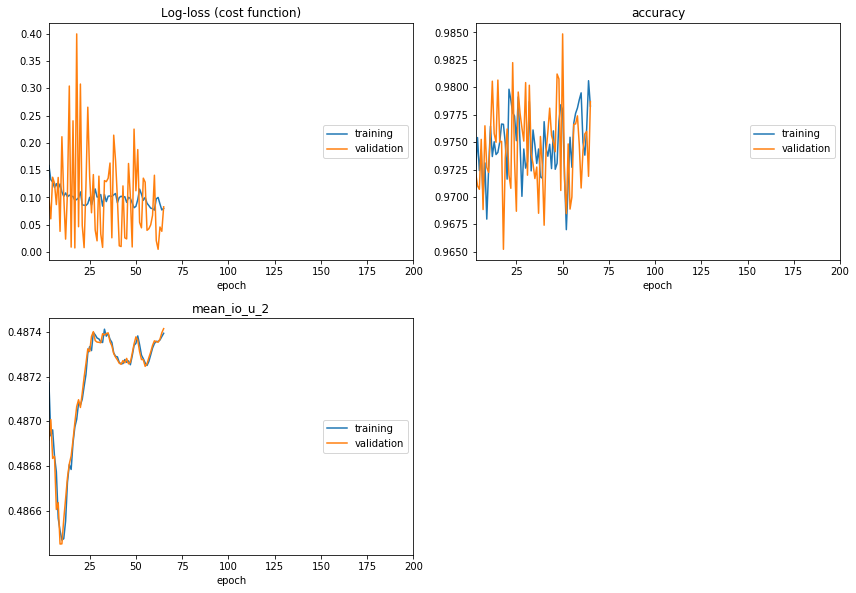

Log-loss (cost function):
training   (min:    0.077, max:    0.472, cur:    0.080)
validation (min:    0.005, max:    0.441, cur:    0.083)

accuracy:
training   (min:    0.836, max:    0.981, cur:    0.978)
validation (min:    0.965, max:    0.985, cur:    0.979)

mean_io_u_2:
training   (min:    0.486, max:    0.487, cur:    0.487)
validation (min:    0.486, max:    0.487, cur:    0.487)
Epoch 66/200
 45/100 [============>.................] - ETA: 28s - loss: 0.0860 - accuracy: 0.9762 - mean_io_u_2: 0.4874

In [ ]:
batch_size = 4
history = model.fit_generator(keras_generator(input_frame, batch_size, input_n),
              steps_per_epoch=100,
              epochs=200,
              callbacks=[PlotLossesCallback(), best_w, last_w],
              validation_data=keras_generator(val_frame, batch_size, input_n),
              validation_steps=50,
              use_multiprocessing=True,
              initial_epoch=0)